# TD : Apprentissage automatique - Approche bayésienne et k-NN

Répondez aux questions dans le document et copiez les lignes de code qui ont produit les résultats aux endroits indiqués.

Le TD comprend 2 parties:
* Une comparaison des approches bayésienne et plus proches voisins pour un problème de classification binaire. Les algorithmes seront codés intégralement en python.
* Une prise en main sur un autre problème de la bibliothèque  [scikit-learn](http://scikit-learn.org/stable/modules/classes.html) qui implémente les mêmes algorithmes.


______

# Introduction: Utilisation de Colab (10min)
______

Dans ce TD, on utilise les ressources proposées par ColaB. Les données seront stockées sur le Goggle Drive associé à votre compte Gmail.

Pour accéder au données depuis Colab, il faut "monter le Gdrive" depuis une session Colab.

Exécutez le cellule suivante pour le faire. il vous sera demandé de saisir une clé d'authentification générée à partir du lien affiché. (Ctrl+Enter ou clic sur la flèche)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Il faut ensuite positionner des variables d'environnement pour indiquer à Colab où se trouvent les données (fichiers python et données d'apprentissage).

Exécutez la cellule suivante pour le faire, et modifiez la variable 'TD_DIR' à l'endroit où vous avez sauvegardé le TD1. 

In [3]:
import sys
import os

# Modifier la variable du TD en fonction de l'endroit où les données sont stockées
TD_DIR = 'gdrive/My Drive/teaching/IOGS/2022/'
sys.path.append(TD_DIR)

______

# Partie 1: Apprentissage automatique en Python
______

On se propose dans cette première partie de construire une démarche d'apprentissage sur un problème simple, et de programmer les deux algorithmes vus dans le cours (bayésien naĩf et plus proches voisins).

Chaque jeu de données est constitué de quatre ensembles :
* Un ensemble de données test utilisées pour l'apprentissage : trainX
* Un ensemble de classes associées aux données d'apprentissage : trainY
* Un ensemble de données à tester : testX
* Un ensemble de classes associées aux données de test : testY

Les données de test ne doivent pas être utilisées pour l'apprentissage proprement dit, seulement pour son évaluation.

Si besoin (validation croisée), les jeux d'apprentissage peuvent être répartis en train + validation.

Remarque: Pour visualiser dans le notebook, appliquer l'instruction:
>```python
plt.show() ```

après chaque fonction de visualisation.


## Activité 1.1 : Bayésien naïf.

On se propose de réaliser une classification binaire d'un ensemble de données en utilisant une approche de type "bayésien naïf".

Le problème est une classification binaire pour détecter des billets de banque frauduleux. Les données source d'origine sont accessible ici https://archive.ics.uci.edu/ml/datasets/banknote+authentication, mais sont aussi présentes sur votre machine. 

L'objectif est de dérouler les différentes étapes d'une démarche d'apprentissage automatique:
1. Constitution de la base d'apprentissage
2. Visualisation des données
3. Choix de l'approche
4. Optimisation
5. Evaluation


### Base d'apprentissage (10min)


<div class="alert alert-block alert-info">

Les données source ont été placées dans le répertoire du TP (fichier 'data_banknote_authentication.txt').

Exécuter le code ci-dessous qui les charge, et qui les répartit en ensemble d'apprentissage et de test (fonction 'train_test_split')

Montrer les tailles des données (nombre de caractéristiques, nombre de données). 

</div>


In [4]:
# Librairies scientifique et visualisation utiles standard
import numpy as np
import matplotlib.pyplot as plt
import random

# Pour séparer les données en apprentissage et test
from sklearn.model_selection import train_test_split

# Pour visualiser  les données
def show_data_2D(X,Y):
    np.unique(Y)
    fig, ax = plt.subplots(figsize=(8, 6))
    for id in np.unique(Y):
        idpositive=np.nonzero(Y == id)[0]
        ax.scatter(X[idpositive,0], X[idpositive,1], s=50)

# Chargement des données et constitution de la base d'apprentissage

X = np.loadtxt(os.path.join(TD_DIR,'data_banknote_authentication.txt'), delimiter=',')
y = X[:,-1]
X = X[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.8)

# MODIFIER LE CODE

print("Les données sont de dimension {:d}".format(X_train.shape[1]))
print("Le nombre de données d'apprentissage est {:d}".format(y_train.shape[0]))


Les données sont de dimension 4
Le nombre de données d'apprentissage est 274


### Visualisation des données (10min)



<div class="alert alert-block alert-info">

Faire des sorties visuelles des distributions de données. Vous pourrez utiliser les fonctions de visualisation "show_data_2D" pour mettre en évidence les corrélations, et [plt.hist](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html) pour visualiser des histogrammes pour chaque classe.

</div>


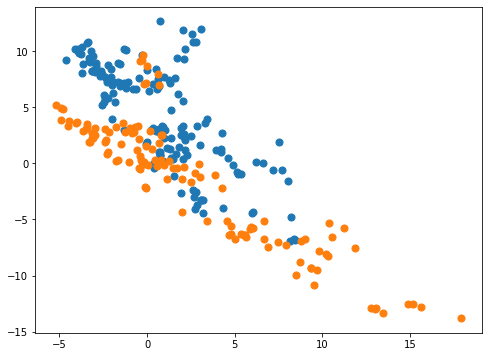

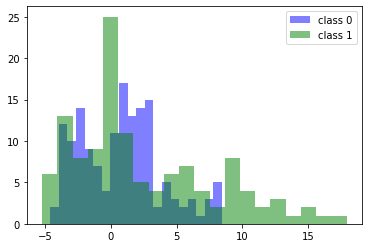

In [6]:


# Dimensions à étudier (à répéter pour d'autres dimensions)
feat1 = 2
feat2 = 1

# Distributions 2D
show_data_2D(X_train[:,[feat1, feat2]], y_train)
plt.show()

X0 = X_train[y_train == 0,:]
X1 = X_train[y_train == 1,:]

# Visualise les distributions pour un attribut
a1 = X0[:,feat1]
b1 = X1[:,feat1]


# METTRE VOTRE CODE ICI

plt.hist(a1, color='b', alpha=0.5, bins=20, label=['class 0'])
plt.hist(b1, color='g', alpha=0.5, bins=20, label=['class 1'])
plt.legend(loc='upper right')
plt.show()


### Choix de l'approche (10min)



<div class="alert alert-block alert-info">

Le principe du bayésien naïf est d'estimer la loi conditionnelle $P[x_i | y]$ pour les différentes hypothèses $y\in\{0,1\}$ et caractéristiques $x_i$.
<br><br>
A partir de la répartition des données pour chaque caractéristique, le principe du choix de l'approche est de sélectionner un bon modèle de cette distribution (binomiale, multinomiale, gaussienne, histogram, mélange de gaussienne...)?
<br><br>
Vous pouvez regarder la bibliothèque [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) qui définit les familles courantes de distributions statistiques.
<br><br>
Essayez d'estimer quelques lois paramétriques pertinentes (méthode 'fit' des classes de scipy.stats) en les superposant aux histogrammes des données. 

</div>


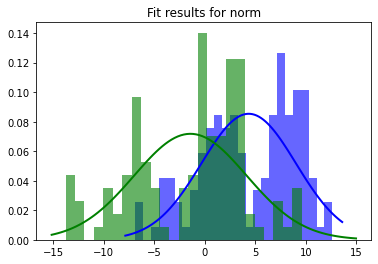

In [8]:
# Choix de la distribution
from scipy.stats import laplace, expon, norm, gamma, beta, cauchy, logistic

# MODIFIER LE CODE ICI
# Changer de distribution
distrib=norm

# Choix de la caractéristique
feat1 = 1
a1 = X0[:,feat1]
b1 = X1[:,feat1]

# Visualise les distributions pour une caractéristique
plt.clf()

data = a1
param = distrib.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = distrib.pdf(x, *param)
plt.plot(x, p, 'b', linewidth=2)

data = b1
param = distrib.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = distrib.pdf(x, *param)
plt.plot(x, p, 'g', linewidth=2)

title = "Fit results for %s" % distrib.name
plt.title(title)

plt.show()



<div class="alert alert-block alert-success">
QUESTION: Quelle est la famille de distributions la plus simple pour décrire les données?
</div>

**Réponse**

Une famille simple vu l'allure des données est la famille des distributions gaussiennes, "norm" (globalement les données sont monomodales). 

### Optimisation du modèle (10min+5min+5min)

<div class="alert alert-block alert-info">
Ecrire une fonction d'estimation qui renvoie le modèle de distribution ou ses paramètres pour l'ensemble des lois conditionnelles. Ce sera le résultat de votre apprentissage! Appliquez-la sur les distributions de chacune des deux classes.
</div>

In [16]:
def build_model(data, distrib):
# METTRE VOTRE CODE ICI
    nfeat = data.shape[1]
    params = []
    for ifeat in range(nfeat):
        par = distrib.fit(data[:,ifeat])
        params.append(par)
    return params

distrib = expon

param0 = build_model(X0, distrib)
param1 = build_model(X1, distrib)

print(param0)


[(-2.6479, 5.120890209868421), (-6.8804, 11.230681965789474), (-4.6067, 5.337017736842105), (-7.6612, 6.802186165131579)]


<div class="alert alert-block alert-info">
Ecrire une fonction 'compute_log_likelihood' qui prédit la classe à partir des données et des modèles de distributions en utilisant une approche bayésienne naïve:
$$\log P[y|\mathbf{x}] \propto \sum_{i=1}^N \log P[x_i|y] + \log P[y]$$
pour chacune des classes $y$ et une donnée à prédire $\mathbf{x}$.
</div>

In [11]:
def compute_log_likelihood(data, distrib, params):
    # METTRE VOTRE CODE ICI
    llk = np.zeros((1,data.shape[0]))
    nfeat = data.shape[1]
    for ifeat in range(nfeat):
        llk = llk + distrib.logpdf(data[:,ifeat], *params[ifeat])
    return llk

# Test de la fonction
llk0 = compute_log_likelihood(X0, distrib, param0)

print(llk0)

[[ -8.69557243  -8.63329305  -8.46043185  -7.68730152 -16.23912735
  -12.42164219 -11.69528302  -8.72139458  -7.84569387  -9.68672414
  -10.68900596 -12.83175632 -11.11210376  -9.3968463   -8.44979403
   -9.48322842  -9.80720086 -11.19292668  -9.33057294  -8.806609
  -12.01425105 -11.19961001  -8.35004044  -8.20741953  -8.30944821
  -14.24515163  -7.60985179  -9.1077248   -9.57967527  -8.52755509
  -12.31300826 -14.40762006  -7.34379395  -7.89440475  -8.30948909
   -8.23658328  -9.18247305  -7.61277804  -9.33685058  -7.40498871
   -7.32897412  -9.70932787 -13.13557224  -7.89786917  -8.36873087
   -9.53735619 -10.64862273  -9.70310677  -8.67023716 -13.37075622
  -10.89058929  -9.11896912  -9.39544805  -7.43680073  -7.51928972
  -12.43778021 -11.77227048 -10.74832569  -9.61649152 -14.98886228
  -13.11384434 -15.31375401  -8.35716551 -10.02652344 -10.5640456
   -9.17666957  -9.01053151  -8.67403697 -11.55871788  -9.58176901
   -8.25659169 -10.11317276  -8.03415154 -12.02221557  -9.5329067

### Evaluation

<div class="alert alert-block alert-info">
Tester les performances du classifieur sur les données d'apprentissage et de test. Pour cela, écrivez une fonction de prédiction utilisant le modèle, appliquez-le sur les données de test et comparez aux vraies valeurs.
</div>

In [17]:
def predic_bayesien_naif(data, distrib, param0, param1):       
    # METTRE VOTRE CODE ICI
    llk0 = compute_log_likelihood(data, distrib, param0)
    llk1 = compute_log_likelihood(data, distrib, param1)

    dllk = llk0 - llk1

    y_predic = (dllk < 0).astype('int')

    return y_predic


y_train_predic = predic_bayesien_naif(X_train, distrib, param0, param1)
y_test_predic = predic_bayesien_naif(X_test, distrib, param0, param1)


nerr_train = (y_train_predic != y_train).sum()
nerr_test = (y_test_predic != y_test).sum()

print("Taux d'erreur sur données de train = {:.1f}%".format(100*nerr_train/X_train.shape[0]))
print("Taux d'erreur sur données de test = {:.1f}%".format(100*nerr_test/X_test.shape[0]))


Taux d'erreur sur données de train = 27.0%
Taux d'erreur sur données de test = 26.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


<div class="alert alert-block alert-success">
QUESTION: Expliquez les différences des valeurs de performance entre ensembles d'apprentissage et de test.
</div>

**Réponse**

Le modèle est appris sur des données en petit nombre, et est donc imprécis.

## Activité 1.2: plus proches voisins (20min)
On va reproduire la séquence d'activité précédente en développant une approche de type 'plus proches voisins', et la valider sur le même jeu de données.

### Choix du modèle


<div class="alert alert-block alert-info">
Les principaux paramètres du modèle sont le type de distance ou de mesure de similarité, et le nombre de voisins à utiliser pour prendre une décision.
</div>

In [18]:
# Choix de la distance de similarité
dist_name = 'euclidean'

# Choix du nombre de voisins
k = 5

### Optimisation


<div class="alert alert-block alert-info">
L'apprentissage d'une approche 'plus proches voisins' consiste simplement à collecter les exemples d'apprentissage et leurs classes.
</div>

In [19]:
# Apprentissage
Bdd_samples = X_train
Bdd_classes = y_train

### Evaluation


<div class="alert alert-block alert-info">
L'évaluation consiste à vérifier que la fonction de prédiction appliquée sur le jeu de test produit des classes identiques à la vérité terrain. 
<br><br>
Ecrivez le corps de la fonction de prédiction 'predic_kNN' prenant en entrée l'ensemble de test, et les paramètres de l'algorithme du plus proche voisin. 
<br><br>
Vous pouvez utiliser les fonctions de calcul de matrices de similarité <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html>cdist</a>, les fonctions de tri de numpy <a href=https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html>argsort</a> et les fonctions de statistiques sur des collections implémentées directement en Python dans la classe <a href=https://docs.python.org/3/library/collections.html#collections.Counter>Counter</a>. Avec ces fonctions, l'algorithme peut tenir en moins de 10 lignes.
</div>

In [20]:

### Calcul de la distance

from scipy.spatial import distance
from collections import Counter

def predic_kNN(X_test, samples, classes, dist_name, k):
    # METTRE VOTRE CODE ICI
    
    # distance entre exemples de tests et exemples d'apprentissage
    S = distance.cdist(X_test, samples, dist_name)

    # ordonne les examples par ordre croissant de distance
    NN = np.argsort(S)

    # Trouve les étiquettes pour chaque voisin
    yNN_predic = classes[NN[:,:k]].astype('int')

    # Vote majoritaire: uniquement valable pour les problèmes à deux classes
    #y_predic = (2*yNN_predic.sum(axis=1) > k).astype('int')

    # Vote majoritaire générique
    y_predic = []
    for itest in range(yNN_predic.shape[0]):
        y_predic.append(Counter(yNN_predic[itest,:]).most_common(1)[0][0])
        
    return y_predic

y_predic = predic_kNN(X_test, Bdd_samples, Bdd_classes, dist_name, k)
nerr = (y_predic != y_test).sum()

print("Taux d'erreur de test {:.1f}%".format(100*nerr/X_test.shape[0]))

Taux d'erreur de test 1.0%


<div class="alert alert-block alert-success">
QUESTION: quelles sont les différences principales par rapport au modèle précédent (Bayésien naïf)?
</div>

**Réponse**

Phase d'apprentissage réduite, temps de calcul plus long, performances meilleures (prise en compte des corrélations entre caractéristiques dans la distance). 

___
# Partie 2 : Utilisation de scikit-learn
___


On se propose dans cette partie d'utiliser la librarie [scikit-learn](http://scikit-learn.org/stable/modules/classes.html) qui contient un rand nombre d'algorithmes d'apprentissage et une interface facile d'utilisation, divisée en deux types de fonctionnalités: 'fit' et 'predict'.


## Activité 2.0: Données (5min)

Le nouveau problème d'apprentissage est une classification binaire de textes en provenance de newsgroups, c'est-à-dire des forums de discussion sur une certaine thématique. L'objectif de la classification est de prédire le groupe où le document a été posté uniquement à partir du texte.

Une première étape de mise en forme des données sous forme vectorielle a été réalisée et utilise une technique de "sac de mots" ("bag of words" en anglais). Les données sont de grande taille, mais très creuses (beaucoup de valeurs nulles par échantillon).

<div class="alert alert-block alert-info">

Chargez les données visualisez quelques exemples. Calculez le nombre moyen de valeurs non nulles par échantillon.

</div>

In [21]:
## Lecture des données
#class0 = 3 #'comp.sys.ibm.pc.hardware',
#class1 = 4 #'comp.sys.mac.hardware'

class0 = 13 # 'sci.med'
class1 = 14 # 'sci.space'


npzfile = np.load(os.path.join(TD_DIR,'2newsgroup_{:d}_{:d}.npz').format(class0,class1),allow_pickle=True)
X = npzfile['arr_0'].tolist().todense()

y = X[:,-1].getA1()
X = X[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.3)

print("Les données sont de dimension {:d}".format(X_train.shape[1]))
print("Le nombre de données d'apprentissage est {:d}".format(y_train.shape[0]))

# METTRE VOTRE CODE ICI
non_nul_moyen = np.mean(np.sum(X_train > 0,axis=1))
print("Le nombre moyen de valeurs non nulles par échantillon est {:.1f}".format(non_nul_moyen))


Les données sont de dimension 24412
Le nombre de données d'apprentissage est 1383
Le nombre moyen de valeurs non nulles par échantillon est 103.8


## Activité 2.1: bayésien naïf (5min)

<div class="alert alert-block alert-info">

La bibliothèque propose une version de l'algorithme [bayésien naif](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) avec plusieurs types de modèles de distributions de probabilités. Quel est le modèle plus adapté au problème parmi les trois proposés?

<br><br>

Ecrivez ensuite la démarche générique d'apprentissage à partir de la bibliothèque scikit-learn.
</div>

In [22]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB

# METTRE VOTRE CODE ICI

bayes = BernoulliNB(binarize=0.0001)
bayes.fit(X_train, y_train)
y_predic = bayes.predict(X_test)

nerr = (y_predic != y_test.ravel()).sum()

print("Taux d'erreur NN = {:.1f}%".format(100*nerr/y_test.shape[0]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Taux d'erreur NN = 6.4%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


## Activité 2.2: Plus proche voisin (5min)


<div class="alert alert-block alert-info">

La bibliothèque scikit-learn propose une version de l'algorithme de classification par [k plus proches voisins](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) avec plusieurs paramétrages possibles.

<br>
Ecrivez la démarche générique d'apprentissage à partir cette bibliothèque, et testez plusieurs paramètres pour améliorer les performances. 

<br><br>
ATTENTION: les calculs peuvent être plus longs que pour les exemples précédents. Une possibilité est de limiter la taille de la base de donnée pour sélectionner les bonnes configurations.

</div>

In [23]:
from sklearn.neighbors import KNeighborsClassifier
import timeit

tic = timeit.default_timer();  

# METTRE VOTRE CODE ICI

neigh = KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='kd_tree', metric='l2')
neigh.fit(X_train, y_train)
y_predic = neigh.predict(X_test)



toc = timeit.default_timer()
print("Temps d'execution = {:.3g} s".format(toc-tic))

nerr = (y_predic != y_test.ravel()).sum()

print("Taux d'erreur NN = {:.1f}%".format(100*nerr/y_test.shape[0]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Temps d'execution = 46.7 s
Taux d'erreur NN = 32.2%
